In [41]:
# Core
import numpy as np
import torch
import matplotlib.pyplot as plt

# Transformer
from transformers import AutoTokenizer, AutoModel

# XAI
from captum.attr import IntegratedGradients

# Chemistry
from rdkit import Chem
from rdkit.Chem import Draw

# Display
from IPython.display import display


In [42]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


In [44]:
# load pre-trained ChemBERTa model
model_name = "seyonec/ChemBERTa-zinc-base-v1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name).to(device)
bert.eval()


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(767, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-5): 6 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [45]:
class BioactivityHead(torch.nn.Module):
    """
    Simple classification head operating on the [CLS] embedding.
    Used only for explainability purposes.
    """
    def __init__(self, hidden_size):
        super().__init__()
        self.fc = torch.nn.Linear(hidden_size, 1)

    def forward(self, hidden_states):
        # Use CLS token (position 0)
        cls_embedding = hidden_states[:, 0, :]
        return torch.sigmoid(self.fc(cls_embedding))


In [46]:
head = BioactivityHead(bert.config.hidden_size).to(device)
head.eval()


BioactivityHead(
  (fc): Linear(in_features=768, out_features=1, bias=True)
)

In [47]:
def forward_from_embeddings(embeddings, attention_mask):
    """
    Forward pass starting from input embeddings.
    This enables gradient-based attribution.
    """
    outputs = bert(
        inputs_embeds=embeddings,
        attention_mask=attention_mask
    )
    return head(outputs.last_hidden_state)


In [48]:
def token_attribution(smiles):
    """
    Compute token-level attribution scores for a SMILES string
    using Integrated Gradients.
    """
    # Tokenize SMILES
    inputs = tokenizer(
        smiles,
        return_tensors="pt",
        truncation=True,
        max_length=128
    ).to(device)

    # Obtain input embeddings (differentiable)
    embeddings = bert.embeddings.word_embeddings(inputs["input_ids"])

    # Baseline: zero embeddings
    baseline = torch.zeros_like(embeddings)

    # Integrated Gradients
    ig = IntegratedGradients(forward_from_embeddings)

    attributions = ig.attribute(
        inputs=embeddings,
        baselines=baseline,
        additional_forward_args=(inputs["attention_mask"],),
        n_steps=50
    )

    # Aggregate attribution across embedding dimensions
    token_scores = attributions.sum(dim=-1).squeeze().detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    return tokens, token_scores


In [49]:
def plot_token_bar(tokens, scores):
    """
    Visualize token-level attribution scores.
    """
    # Normalize scores for visualization
    scores = scores / (np.abs(scores).max() + 1e-6)

    plt.figure(figsize=(14, 3))
    plt.bar(range(len(tokens)), scores, color="red")
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.ylabel("Attribution Score")
    plt.title("SMILES Token-Level Attribution")
    plt.tight_layout()
    plt.show()


In [50]:
def atom_attribution_from_tokens(smiles, tokens, scores):
    """
    Map token-level attribution scores to atom-level scores.
    This is a heuristic but widely used approach in SMILES XAI.
    """
    mol = Chem.MolFromSmiles(smiles)
    atom_scores = np.zeros(mol.GetNumAtoms())

    atom_idx = 0
    for token, score in zip(tokens, scores):
        # Skip special tokens
        if token in ["[CLS]", "[SEP]", "[PAD]"]:
            continue

        # Remove subword prefix
        if token.startswith("##"):
            token = token[2:]

        # Assign token score to corresponding atoms
        for _ in token:
            if atom_idx < mol.GetNumAtoms():
                atom_scores[atom_idx] += score
                atom_idx += 1

    return mol, atom_scores


In [51]:
def draw_atom_heatmap(mol, atom_scores, threshold=0.15):
    """
    Draw molecule with highlighted atoms based on attribution scores.
    """
    # Normalize atom scores
    atom_scores = atom_scores / (np.max(np.abs(atom_scores)) + 1e-6)

    # Highlight important atoms
    highlight_atoms = [
        i for i, s in enumerate(atom_scores) if abs(s) > threshold
    ]

    highlight_colors = {
        i: (1.0, 0.0, 0.0, abs(atom_scores[i]))
        for i in highlight_atoms
    }

    return Draw.MolToImage(
        mol,
        highlightAtoms=highlight_atoms,
        highlightAtomColors=highlight_colors,
        size=(500, 300)
    )


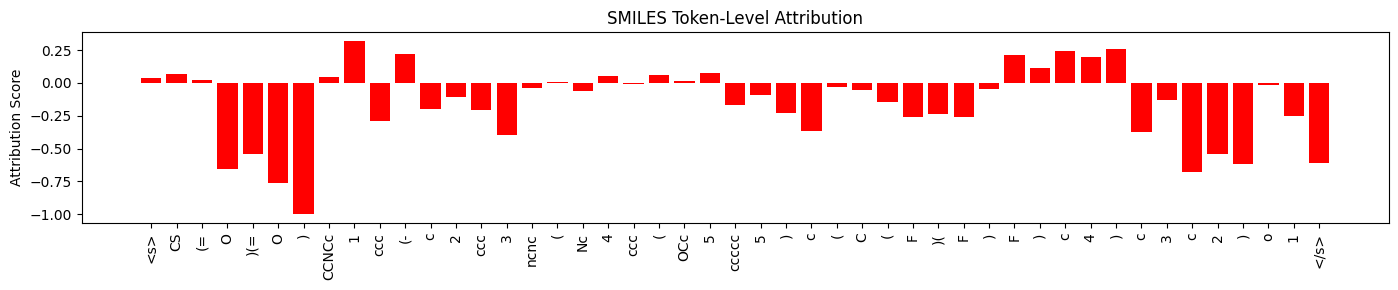

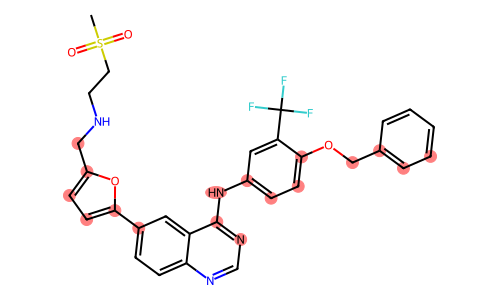

In [53]:
# Example molecule
smiles = "CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccccc5)c(C(F)(F)F)c4)c3c2)o1"

# Token-level attribution
tokens, scores = token_attribution(smiles)
plot_token_bar(tokens, scores)

# Atom-level attribution
mol, atom_scores = atom_attribution_from_tokens(smiles, tokens, scores)
img = draw_atom_heatmap(mol, atom_scores)
display(img)
